In [7]:
%pip install --upgrade pip
%pip install numpy pandas matplotlib scikit-learn
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import re
import sys
from pathlib import Path
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler  # used by loaded scalers

# ---------------- PATHS: local Windows folder + CSV I/O ----------------
BASE_DIR = r"C:\Users\emine\source\repos\Dynamo\Dynamo"

# Path to the single combined file with columns: Datetime, consumption, production, houseId
COMBINED_PATH = str(Path(BASE_DIR, "Combined_PV_Load_AllHouses.csv"))

# One combined output file for all houses (CSV):
COMBINED_OUTPUT_PATH = str(Path(BASE_DIR, "Forecast_day_ahead_ALL_HOUSES.csv"))

# List of houses with their IDs (must match 'houseId' values in the combined file)
HOUSES: List[Dict[str, str]] = [
    {
        "houseId": "Andreas",
        "pv_pth":   str(Path(BASE_DIR, "AndreasC_PVProd.pth")),
        "load_pth": str(Path(BASE_DIR, "AndreasC_Consumption.pth")),
    },
    {
        "houseId": "Eleni",
        "pv_pth":   str(Path(BASE_DIR, "Kimonidou_Eleni_PVProd.pth")),
        "load_pth": str(Path(BASE_DIR, "kimonidou_Eleni_LoadCons.pth")),
    },
    {
        "houseId": "Yiannis",
        "pv_pth":   str(Path(BASE_DIR, "Yiannis_Michaelides_PVProd.pth")),
        "load_pth": str(Path(BASE_DIR, "Yiannis_LoadCons.pth")),
    },
]

# 5-min cadence
STEP_MINUTES = 5
SAMPLES_PER_HOUR = 60 // STEP_MINUTES  # 12
FULL_DAY_STEPS = 24 * SAMPLES_PER_HOUR  # 288

# Clamp tiny PV predictions
CLAMP_VALUE = 0.01

# ---------------- Reliability settings ----------------
# Load reliability: IQR-based scale with exp mapping (smooth, avoids hard zero)
LOAD_REL_FRACTION = 1.50
LOAD_REL_FLOOR    = 400.0  # Wh per 5-min floor for the IQR scale

# PV reliability: linear mapping using P95 level with a floor
PV_REL_FRACTION   = 0.30
PV_REL_FLOOR      = 50.0

DEFAULT_RELIABILITY = 0.50

# Load “low activity” detection for base fallback
LOW_ACTIVITY_THRES = 20.0   # Wh per 5-min; if median(yesterday) < this → fallback base

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --------------------------------- MODEL --------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, horizon=1, dropout_rate=0.0):
        super().__init__()
        self.horizon = horizon
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        yhat = self.fc(last)
        return yhat

# ------------------------- HELPERS (Shared/Generic) ---------------------------
def safe_name(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9._-]+', '_', str(s)).strip('_')

def inv_transform_matrix(scaler, mat_2d: np.ndarray) -> np.ndarray:
    flat = mat_2d.reshape(-1, 1)
    inv = scaler.inverse_transform(flat).reshape(mat_2d.shape)
    return inv

def hour_of_week(ts: pd.Timestamp) -> int:
    """5-min HOW index [0..(7*24*12 - 1)]."""
    return int(ts.dayofweek) * (24 * SAMPLES_PER_HOUR) + int(ts.hour) * SAMPLES_PER_HOUR + int(ts.minute // (60 // SAMPLES_PER_HOUR))

def build_residual_bank(datetimes: pd.Series, window_size: int, horizon: int, err_matrix: np.ndarray) -> Tuple[pd.DataFrame, pd.Series, pd.Series, Optional[float]]:
    """
    Create residual bank and q90 lookup from errors shaped (N,H) for a sequential datetime series.
    """
    how_list, h_list, ae_list = [], [], []
    N, H = err_matrix.shape
    dt = pd.to_datetime(datetimes).reset_index(drop=True)
    for i in range(N):
        base = i + window_size
        for h in range(H):
            idx = base + h
            if idx >= len(dt):
                break
            t = pd.to_datetime(dt.iloc[idx])
            how_list.append(hour_of_week(t))
            h_list.append(h + 1)
            ae_list.append(float(err_matrix[i, h]))
    bank = pd.DataFrame({"how": how_list, "h": h_list, "ae": ae_list})
    if bank.empty:
        return bank, pd.Series(dtype=float), pd.Series(dtype=float), None
    q90_how_h = bank.groupby(["how", "h"])["ae"].quantile(0.90)
    q90_by_h  = bank.groupby("h")["ae"].quantile(0.90)
    q90_global = float(bank["ae"].quantile(0.90))
    return bank, q90_how_h, q90_by_h, q90_global

# -------------------- LOAD CONSUMPTION PIPELINE (Residual) --------------------
class TimeSeriesDataset(torch.utils.data.Dataset):
    """
    Expects scaled features X (T x F), scaled residual target y_resid (T x 1),
    and absolute target y_abs (T x 1) for reconstructing absolute paths.
    Returns per item:
      (x_seq, y_resid_vec_scaled, y_yday_vec_abs, y_true_vec_abs)
    """
    def __init__(self, X, y_resid_scaled, y_abs_unscaled, window_size, horizon):
        self.X = X
        self.y_resid = y_resid_scaled.squeeze(-1)
        self.y_abs   = y_abs_unscaled.squeeze(-1)
        self.window_size = window_size
        self.horizon = horizon

    def __len__(self):
        return max(0, len(self.X) - self.window_size - self.horizon + 1)

    def __getitem__(self, idx):
        t = idx + self.window_size - 1
        x_seq = self.X[idx : idx + self.window_size]
        y_resid_vec = self.y_resid[idx + self.window_size : idx + self.window_size + self.horizon]
        y_yday_vec  = self.y_abs[t - (self.horizon-1) : t + 1]
        y_true_vec  = self.y_abs[t + 1 : t + 1 + self.horizon]
        return (torch.tensor(x_seq, dtype=torch.float32),
                torch.tensor(y_resid_vec, dtype=torch.float32),
                torch.tensor(y_yday_vec,  dtype=torch.float32),
                torch.tensor(y_true_vec,  dtype=torch.float32))

def prepare_data_for_model_consumption(df_in: pd.DataFrame, target_col: str, is_training=True) -> pd.DataFrame:
    """Computes lag_24h, lag_168h (fallback), residuals, calendar & rolling features."""
    dfp = df_in.copy()
    if not isinstance(dfp.index, pd.DatetimeIndex):
        if 'Datetime' not in dfp.columns:
            raise KeyError("'Datetime' missing for feature prep (consumption).")
        dfp['Datetime'] = pd.to_datetime(dfp['Datetime'])
        dfp = dfp.set_index('Datetime').sort_index()

    # Ensure single instance of target column name
    if isinstance(target_col, str) and (dfp.columns.tolist().count(target_col) > 1):
        dfp = dfp.loc[:, ~dfp.columns.duplicated(keep='first')]

    SAMPLES_PER_DAY  = 24 * SAMPLES_PER_HOUR
    SAMPLES_PER_WEEK = 7  * SAMPLES_PER_DAY

    dfp['lag_24h']   = dfp[target_col].shift(SAMPLES_PER_DAY)
    dfp['lag_168h']  = dfp[target_col].shift(SAMPLES_PER_WEEK)

    na_mask = dfp['lag_168h'].isna()
    if na_mask.any():
        dfp.loc[na_mask, 'lag_168h'] = dfp.loc[na_mask, 'lag_24h']

    dfp['diff_from_lag_24h'] = dfp[target_col] - dfp['lag_24h']

    dfp['is_weekend'] = dfp.index.dayofweek.isin([5,6]).astype(int)
    dfp['hour_of_week'] = (
        dfp.index.dayofweek * (24 * SAMPLES_PER_HOUR) +
        dfp.index.hour      * SAMPLES_PER_HOUR +
        (dfp.index.minute // (60 // SAMPLES_PER_HOUR))
    )
    dfp['hour_of_week_sin'] = np.sin(2*np.pi*dfp['hour_of_week']/(7*24*SAMPLES_PER_HOUR))
    dfp['hour_of_week_cos'] = np.cos(2*np.pi*dfp['hour_of_week']/(7*24*SAMPLES_PER_HOUR))
    dfp['month']            = dfp.index.month
    dfp['month_sin']        = np.sin(2*np.pi*dfp['month']/12.0)
    dfp['month_cos']        = np.cos(2*np.pi*dfp['month']/12.0)

    dfp['rolling_std_1h']         = dfp[target_col].shift(1).rolling(window=SAMPLES_PER_HOUR).std()
    dfp['rolling_mean_1h']        = dfp[target_col].shift(1).rolling(window=SAMPLES_PER_HOUR).mean()
    dfp['deviation_from_mean_1h'] = dfp[target_col] - dfp['rolling_mean_1h']
    dfp['load_diff_1step']        = dfp[target_col].diff(1)
    dfp['load_acceleration']      = dfp[target_col].diff(2)
    rolling_30 = dfp[target_col].shift(1).rolling(window=max(1, SAMPLES_PER_HOUR//2))
    dfp['rolling_range_30min']    = rolling_30.max() - rolling_30.min()

    if is_training:
        dfp = dfp.dropna()

    return dfp.reset_index()

# ------------------------ PV PIPELINE (Sparsity mapping) ----------------------
def add_rolling_features(df: pd.DataFrame, columns: List[str], windows: List[int]) -> pd.DataFrame:
    df_new = df.copy()
    for col in columns:
        for window in windows:
            df_new[f"{col}_roll{window}_mean"] = df_new[col].rolling(window).mean().shift(1)
    return df_new

def create_dataset(X: np.ndarray, y: Optional[np.ndarray], window_size: int, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - window_size - horizon + 1):
        Xs.append(X[i : i + window_size])
        if y is not None:
            ys.append(y[i + window_size : i + window_size + horizon, 0])
    return (np.array(Xs), np.array(ys)) if y is not None else np.array(Xs)

def prepare_data_for_model_pv(df: pd.DataFrame, target_col: str,
                              sparsity_start, sparsity_end,
                              rolling_cols: List[str], rolling_windows: List[int],
                              feature_list: List[str], is_training=True) -> pd.DataFrame:
    """Drop sparsity window, interpolate, add time & rolling features (as in your PV script)."""
    df_processed = df.copy()
    df_processed['Datetime'] = pd.to_datetime(df_processed['Datetime'])
    df_processed['time_only'] = df_processed['Datetime'].dt.time

    if sparsity_start < sparsity_end:
        mask = ~df_processed['time_only'].between(sparsity_start, sparsity_end)
    else:
        mask = ~((df_processed['time_only'] >= sparsity_start) | (df_processed['time_only'] <= sparsity_end))
    df_processed = df_processed[mask].reset_index(drop=True).drop(columns=['time_only'])

    df_processed.replace('---', np.nan, inplace=True)
    df_processed[target_col] = pd.to_numeric(df_processed[target_col], errors='coerce')
    df_processed.set_index('Datetime', inplace=True)
    df_processed.interpolate(method='time', inplace=True)
    df_processed.reset_index(inplace=True)

    df_processed["hour"] = pd.to_datetime(df_processed["Datetime"]).dt.hour
    df_processed["dayofyear"] = pd.to_datetime(df_processed["Datetime"]).dt.dayofyear
    df_processed["hour_sin"] = np.sin(2 * np.pi * df_processed["hour"] / 24.0)
    df_processed["hour_cos"] = np.cos(2 * np.pi * df_processed["hour"] / 24.0)
    df_processed["dayofyear_sin"] = np.sin(2 * np.pi * df_processed["dayofyear"] / 365.0)
    df_processed["dayofyear_cos"] = np.cos(2 * np.pi * df_processed["dayofyear"] / 365.0)
    df_processed = add_rolling_features(df_processed, rolling_cols, rolling_windows)

    subset_to_check = feature_list + ([target_col] if is_training else [])
    if is_training:
        df_processed.dropna(subset=subset_to_check, inplace=True)
    df_processed = df_processed.reset_index(drop=True)
    return df_processed

# -------------------------------- MAIN RUNNERS --------------------------------
def run_load_forecast_for_house(df_house: pd.DataFrame, model_pth: str) -> pd.DataFrame:
    """Run consumption forecast for a single house subset; return 24h path with ONE reliability scalar."""
    if not os.path.exists(model_pth):
        raise FileNotFoundError(f"Load model package not found: {model_pth}")

    pkg = torch.load(model_pth, map_location=DEVICE, weights_only=False)
    hp           = pkg['hyperparameters']
    scaler_x     = pkg['scaler_x']
    scaler_y     = pkg['scaler_y']          # residual scaler
    final_feats  = pkg['input_features']
    target_col   = pkg['target_column']
    WINDOW_SIZE  = pkg.get('window_size', hp['window_size'])
    HORIZON      = pkg.get('horizon', hp['horizon'])

    # Map combined 'consumption' -> model's target column
    df_new = df_house[['Datetime', 'consumption']].copy()
    df_new = df_new.sort_values('Datetime').reset_index(drop=True)
    df_new[target_col] = pd.to_numeric(df_new['consumption'], errors='coerce').abs()

    # If training features referenced 'Consumption', mirror it — but avoid duplicates.
    if ('Consumption' in final_feats) and ('Consumption' not in df_new.columns) and (target_col != 'Consumption'):
        df_new['Consumption'] = df_new[target_col].values

    # Minimal column set without duplicates
    cols = ['Datetime', target_col]
    if ('Consumption' in df_new.columns) and ('Consumption' != target_col):
        cols.append('Consumption')

    # Build model ONCE and load weights
    model = LSTMModel(
        input_dim=len(final_feats),
        hidden_dim=hp['hidden_dim'],
        num_layers=hp['num_layers'],
        horizon=HORIZON,
        dropout_rate=hp['dropout_rate']
    ).to(DEVICE)
    model.load_state_dict(pkg['model_state_dict'])
    model.eval()

    # ---------- Backtest (for reliability) ----------
    df_bt = prepare_data_for_model_consumption(df_new[cols], target_col=target_col, is_training=True)
    have_bt = len(df_bt) >= (WINDOW_SIZE + HORIZON)
    if have_bt:
        X_bt_df      = df_bt[final_feats]
        X_bt_scaled  = scaler_x.transform(X_bt_df)
        y_bt_resid   = scaler_y.transform(df_bt[['diff_from_lag_24h']].values.astype(np.float32))
        y_bt_abs     = df_bt[[target_col]].values.astype(np.float32)

        bt_dataset = TimeSeriesDataset(X_bt_scaled, y_bt_resid, y_bt_abs, WINDOW_SIZE, HORIZON)
        bt_loader  = torch.utils.data.DataLoader(bt_dataset, batch_size=128, shuffle=False)

        preds_abs, trues_abs = [], []
        with torch.no_grad():
            for xb, yres_s_vec, y_yday_vec, y_true_vec in bt_loader:
                xb = xb.to(DEVICE)
                yhat_resid_s = model(xb).cpu().numpy()          # (B,H)
                yhat_resid   = scaler_y.inverse_transform(yhat_resid_s.reshape(-1,1)).reshape(yhat_resid_s.shape)
                y_abs_pred   = y_yday_vec.numpy() + yhat_resid
                preds_abs.append(y_abs_pred)
                trues_abs.append(y_true_vec.numpy())
        preds_abs = np.vstack(preds_abs)
        trues_abs = np.vstack(trues_abs)

        # House-level typical error (q90) across all backtest residuals
        err = np.abs(trues_abs - preds_abs).reshape(-1)
        q90_house = float(np.nanpercentile(err, 90))

        # House-level scale from IQR (P95 - P05), then smooth mapping r = exp(-q90/S)
        p95 = float(np.nanpercentile(df_bt[target_col].values, 95))
        p05 = float(np.nanpercentile(df_bt[target_col].values, 5))
        iqr = max(0.0, p95 - p05)
        S_house = LOAD_REL_FRACTION * max(LOAD_REL_FLOOR, iqr)
        r_load_24h = float(np.exp(-q90_house / S_house)) if np.isfinite(S_house) and S_house > 0 else DEFAULT_RELIABILITY
    else:
        r_load_24h = DEFAULT_RELIABILITY

    # ---------- Final 24h forecast (single origin) ----------
    df_feat_all = prepare_data_for_model_consumption(df_new[cols], target_col=target_col, is_training=False)
    missing_feats_all = [c for c in final_feats if c not in df_feat_all.columns]
    if missing_feats_all:
        raise KeyError(f"[LOAD] Missing required features for inference: {missing_feats_all}")

    X_all_df = df_feat_all[final_feats]
    if len(X_all_df) < WINDOW_SIZE:
        raise ValueError("[LOAD] Not enough rows to build the final window for inference.")

    last_window_df     = X_all_df.iloc[-WINDOW_SIZE:]
    last_window_scaled = scaler_x.transform(last_window_df)
    x_tensor = torch.tensor(last_window_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        yhat_resid_s = model(x_tensor).cpu().numpy()[0]  # (H,)
    yhat_resid = scaler_y.inverse_transform(yhat_resid_s.reshape(-1,1)).ravel()

    # --------- Base fallback logic for forecast reconstruction ---------
    SAMPLES_PER_WEEK = 7 * 24 * SAMPLES_PER_HOUR
    # Base option 1: yesterday (last H points)
    yesterday_path = df_new[target_col].iloc[-HORIZON:].values.astype(float)

    use_yesterday = True
    if np.nanmedian(yesterday_path) < LOW_ACTIVITY_THRES:
        # Try base option 2: last week same window
        if len(df_new) >= HORIZON + SAMPLES_PER_WEEK:
            weekago_path = df_new[target_col].iloc[-HORIZON - SAMPLES_PER_WEEK : -SAMPLES_PER_WEEK].values.astype(float)
            if np.isfinite(np.nanmedian(weekago_path)) and np.nanmedian(weekago_path) >= LOW_ACTIVITY_THRES:
                base = weekago_path
                use_yesterday = False
            else:
                base = None
        else:
            base = None

        # If week-ago unavailable/also low → base option 3: hour-of-week mean
        if base is None:
            hist = df_new.iloc[:-HORIZON] if len(df_new) > HORIZON else df_new.copy()
            hist = hist.dropna(subset=[target_col]).copy()
            if not hist.empty:
                hist['Datetime'] = pd.to_datetime(hist['Datetime'])
                hist['how'] = hist['Datetime'].apply(hour_of_week)
                mean_by_how = hist.groupby('how')[target_col].mean()
                last_ts = pd.to_datetime(df_new['Datetime']).iloc[-1]
                forecast_times = [last_ts + pd.Timedelta(minutes=STEP_MINUTES*(i+1)) for i in range(HORIZON)]
                base_vals = []
                global_med = float(np.nanmedian(hist[target_col].values)) if hist[target_col].notna().any() else 0.0
                for ft in forecast_times:
                    how = hour_of_week(pd.to_datetime(ft))
                    val = float(mean_by_how.get(how, global_med))
                    base_vals.append(val)
                base = np.asarray(base_vals, dtype=float)
                use_yesterday = False
            else:
                base = yesterday_path
                use_yesterday = True
    else:
        base = yesterday_path

    # Build forecast
    forecast_abs = base + yhat_resid

    # Time index for output
    last_ts = pd.to_datetime(df_new['Datetime']).iloc[-1]
    forecast_times = [last_ts + pd.Timedelta(minutes=STEP_MINUTES*(i+1)) for i in range(HORIZON)]

    load_df = pd.DataFrame({
        "Datetime": forecast_times,
        "Forecasted_Load_Consumption": forecast_abs,
        "Reliability_Load_24h": r_load_24h  # single scalar repeated for the house
    })
    return load_df

def run_pv_forecast_for_house(df_house: pd.DataFrame, model_pth: str) -> pd.DataFrame:
    """Run PV forecast for a single house subset; return day-ahead grid with ONE reliability scalar."""
    if not os.path.exists(model_pth):
        raise FileNotFoundError(f"PV model package not found: {model_pth}")

    model_package = torch.load(model_pth, map_location=DEVICE, weights_only=False)

    hyperparameters       = model_package['hyperparameters']
    scaler_x              = model_package['scaler_x']
    scaler_y              = model_package['scaler_y']
    final_input_features  = model_package['input_features']
    target_column         = model_package['target_column']
    time_series_features  = model_package['time_series_features']
    rolling_windows       = model_package['rolling_windows']
    window_size           = hyperparameters['window_size']
    horizon               = hyperparameters['horizon']
    sparsity_start_time   = model_package['sparsity_start_time']
    sparsity_end_time     = model_package['sparsity_end_time']

    # Rebuild model & load weights
    model = LSTMModel(
        input_dim=len(final_input_features),
        hidden_dim=hyperparameters['hidden_dim'],
        num_layers=hyperparameters['num_layers'],
        horizon=horizon,
        dropout_rate=hyperparameters['dropout_rate']
    ).to(DEVICE)
    model.load_state_dict(model_package['model_state_dict'])
    model.eval()

    # Map combined 'production' -> model's target column
    df_inference_raw = df_house[['Datetime', 'production']].copy()
    df_inference_raw = df_inference_raw.sort_values('Datetime').reset_index(drop=True)
    df_inference_raw[target_column] = pd.to_numeric(df_inference_raw['production'], errors='coerce')

    # Prepare test features (drop sparsity window; interpolate; add rollings)
    df_test = prepare_data_for_model_pv(
        df=df_inference_raw.rename(columns={"Datetime": "Datetime"}),
        target_col=target_column,
        sparsity_start=sparsity_start_time,
        sparsity_end=sparsity_end_time,
        rolling_cols=time_series_features,
        rolling_windows=rolling_windows,
        feature_list=final_input_features,
        is_training=False
    )

    # -------------------- PV Backtest (for reliability) --------------------
    df_bt_pv = df_test.dropna(subset=[target_column]).reset_index(drop=True)
    if len(df_bt_pv) >= (window_size + horizon):
        X_bt_scaled = scaler_x.transform(df_bt_pv[final_input_features])
        y_bt        = df_bt_pv[[target_column]].values.astype(np.float32)
        X_seq, y_seq = create_dataset(X_bt_scaled, y_bt, window_size, horizon)

        preds_s = []
        BS = 256
        for i in range(0, len(X_seq), BS):
            xb = torch.tensor(X_seq[i:i+BS], dtype=torch.float32).to(DEVICE)
            with torch.no_grad():
                preds_s.append(model(xb).cpu().numpy())
        preds_s = np.vstack(preds_s)
        preds_abs = inv_transform_matrix(scaler_y, preds_s)

        err = np.abs(y_seq - preds_abs).reshape(-1)
        q90_house = float(np.nanpercentile(err, 90))

        p95_level = float(np.nanpercentile(df_bt_pv[target_column].values, 95))
        S_house   = PV_REL_FRACTION * max(PV_REL_FLOOR, p95_level)
        r_pv_24h  = float(np.clip(1.0 - (q90_house / S_house), 0.0, 1.0)) if np.isfinite(S_house) and S_house > 0 else DEFAULT_RELIABILITY
    else:
        r_pv_24h = DEFAULT_RELIABILITY

    # -------------------- Single-origin day-ahead forecast --------------------
    X_test_scaled = scaler_x.transform(df_test[final_input_features])
    if len(X_test_scaled) < window_size:
        raise ValueError("[PV] Not enough rows to build the final window for inference.")

    last_seq_unscaled = df_test[final_input_features].iloc[-window_size:].values
    last_seq_scaled   = scaler_x.transform(last_seq_unscaled)
    x0                = torch.tensor(last_seq_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        forecast_s = model(x0).cpu().numpy()
    prod_day_forecast = inv_transform_matrix(scaler_y, forecast_s).flatten()
    prod_day_forecast[prod_day_forecast < CLAMP_VALUE] = 0

    # Build full 24h 5-min grid after the last timestamp in df_test
    last_timestamp = pd.to_datetime(df_test['Datetime']).iloc[-1]
    full_day_timestamps = pd.to_datetime(
        [last_timestamp + pd.Timedelta(minutes=STEP_MINUTES * (i + 1)) for i in range(FULL_DAY_STEPS)]
    )
    forecast_df = pd.DataFrame({'Datetime': full_day_timestamps})
    forecast_df['time_only'] = forecast_df['Datetime'].dt.time

    # Determine active (non-sparsity) slots to map model horizon
    if sparsity_start_time < sparsity_end_time:
        active_mask = ~forecast_df['time_only'].between(sparsity_start_time, sparsity_end_time)
    else:
        active_mask = ~((forecast_df['time_only'] >= sparsity_start_time) |
                        (forecast_df['time_only'] <= sparsity_end_time))

    active_indices = forecast_df.index[active_mask].to_numpy()
    map_len = min(len(active_indices), len(prod_day_forecast))

    pv_series = np.zeros(len(forecast_df), dtype=float)
    if map_len > 0:
        pv_series[active_indices[:map_len]] = prod_day_forecast[:map_len]

    out = forecast_df.drop(columns=['time_only']).copy()
    out['Forecasted_PV'] = pv_series
    out['Reliability_PV_24h'] = r_pv_24h  # single scalar repeated for the house
    return out

# ----------------------------------- MAIN -------------------------------------
def main():
    # 0) Load combined CSV
    if not os.path.exists(COMBINED_PATH):
        raise FileNotFoundError(f"Combined file not found: {COMBINED_PATH}")

    # Read CSV (sheet concept doesn’t apply)
    df_all = pd.read_csv(COMBINED_PATH)

    # Normalize columns expected: Datetime, consumption, production, houseId
    rename_map = {c: c.strip() if isinstance(c, str) else c for c in df_all.columns}
    df_all.rename(columns=rename_map, inplace=True)
    if 'Datetime' not in df_all.columns:
        for cand in ['datetime', 'Timestamp', 'timestamp']:
            if cand in df_all.columns:
                df_all.rename(columns={cand: 'Datetime'}, inplace=True)
                break
    missing_cols = [c for c in ['Datetime', 'consumption', 'production', 'houseId'] if c not in df_all.columns]
    if missing_cols:
        raise KeyError(f"Combined file missing required columns: {missing_cols}")

    df_all['Datetime'] = pd.to_datetime(df_all['Datetime'], errors='coerce')
    df_all = df_all.dropna(subset=['Datetime']).sort_values(['houseId', 'Datetime']).reset_index(drop=True)

    # Collect per-house forecasts to concatenate
    all_forecasts = []

    # 1) Loop houses
    for cfg in HOUSES:
        house_id = cfg['houseId']
        print(f"\n==================== HOUSE: {house_id} ====================")
        df_house = df_all[df_all['houseId'] == house_id].copy()
        if df_house.empty:
            print(f"[{house_id}] No rows found in combined file; skipping.")
            continue

        # 2) Run forecasts
        load_df = run_load_forecast_for_house(df_house, cfg['load_pth'])
        pv_df   = run_pv_forecast_for_house(df_house, cfg['pv_pth'])

        # 3) Align on Datetime and combine
        merged = pd.merge(
            pv_df[['Datetime', 'Forecasted_PV', 'Reliability_PV_24h']],
            load_df[['Datetime', 'Forecasted_Load_Consumption', 'Reliability_Load_24h']],
            on='Datetime', how='outer'
        ).sort_values('Datetime').reset_index(drop=True)

        # Add House_ID column
        merged.insert(0, 'House_ID', house_id)

        # Accumulate
        all_forecasts.append(merged)

    if not all_forecasts:
        raise RuntimeError("No forecasts produced for any house (check HOUSES list and combined file contents).")

    # 4) Concatenate all houses and save ONE CSV
    combined_out = pd.concat(all_forecasts, axis=0, ignore_index=True)
    combined_out = combined_out.sort_values(['House_ID', 'Datetime']).reset_index(drop=True)

    out_path = Path(COMBINED_OUTPUT_PATH)
    combined_out.to_csv(out_path, index=False)
    print(f"\nSaved ALL houses ({len(combined_out)} rows) to {out_path}")

if __name__ == "__main__":
    try:
        main()
    except Exception as exc:
        print(f"FAILED: {exc}", file=sys.stderr)
        sys.exit(1)


Using device: cpu

==================== HOUSE: Andreas ====================

==================== HOUSE: Eleni ====================


D:\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\MachineLearning\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\MachineLearning\Lib\site-packages\sklearn\b


==================== HOUSE: Yiannis ====================

Saved ALL houses (864 rows) to C:\Users\emine\source\repos\Dynamo\Dynamo\Forecast_day_ahead_ALL_HOUSES.csv


D:\MachineLearning\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\MachineLearning\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\MachineLearning\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more inf

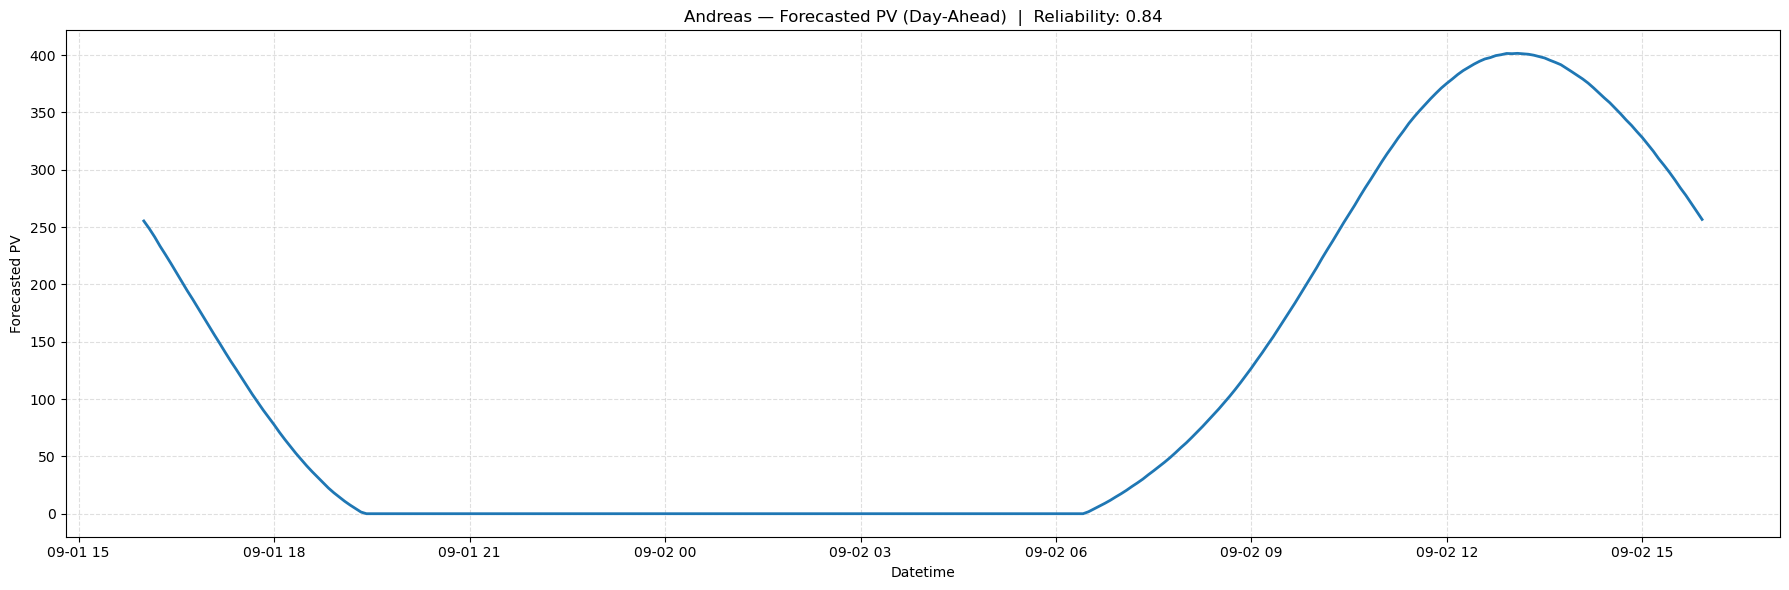

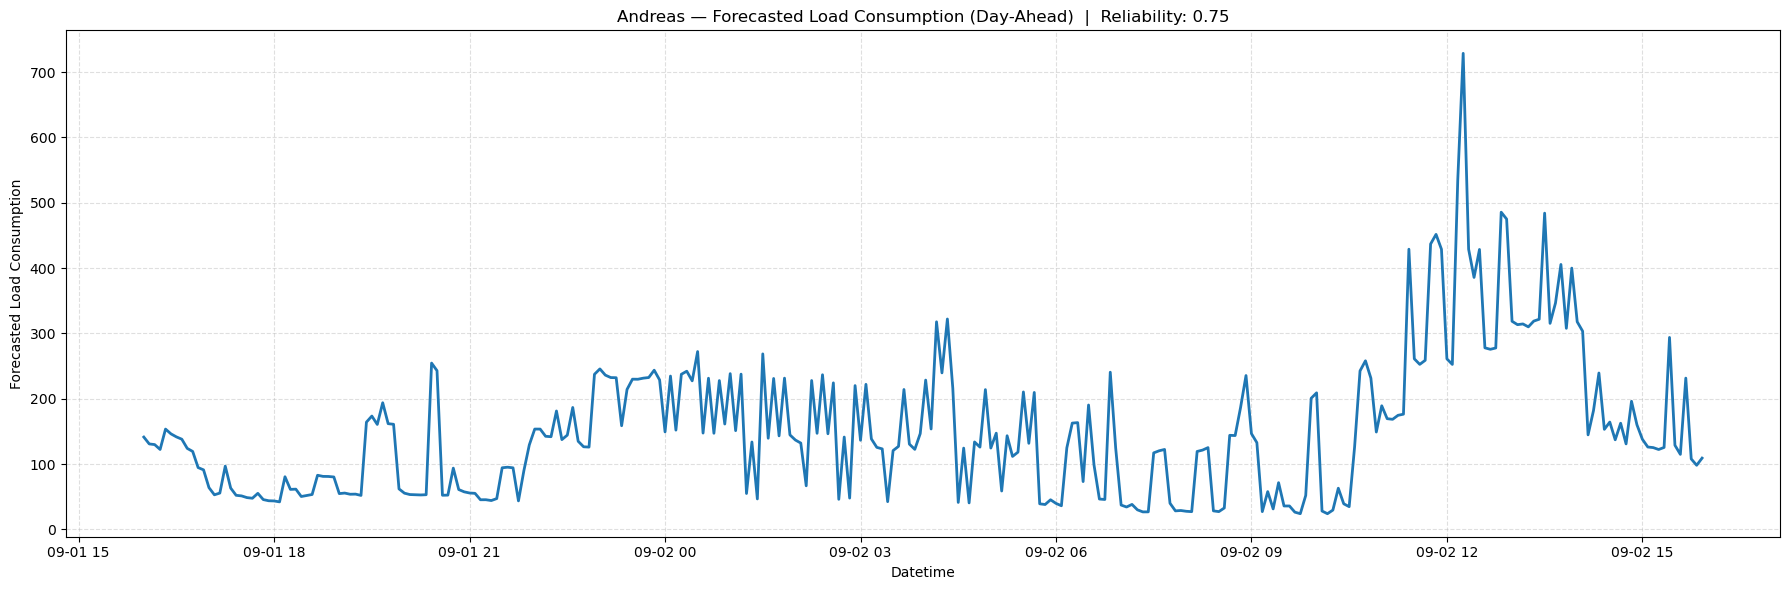

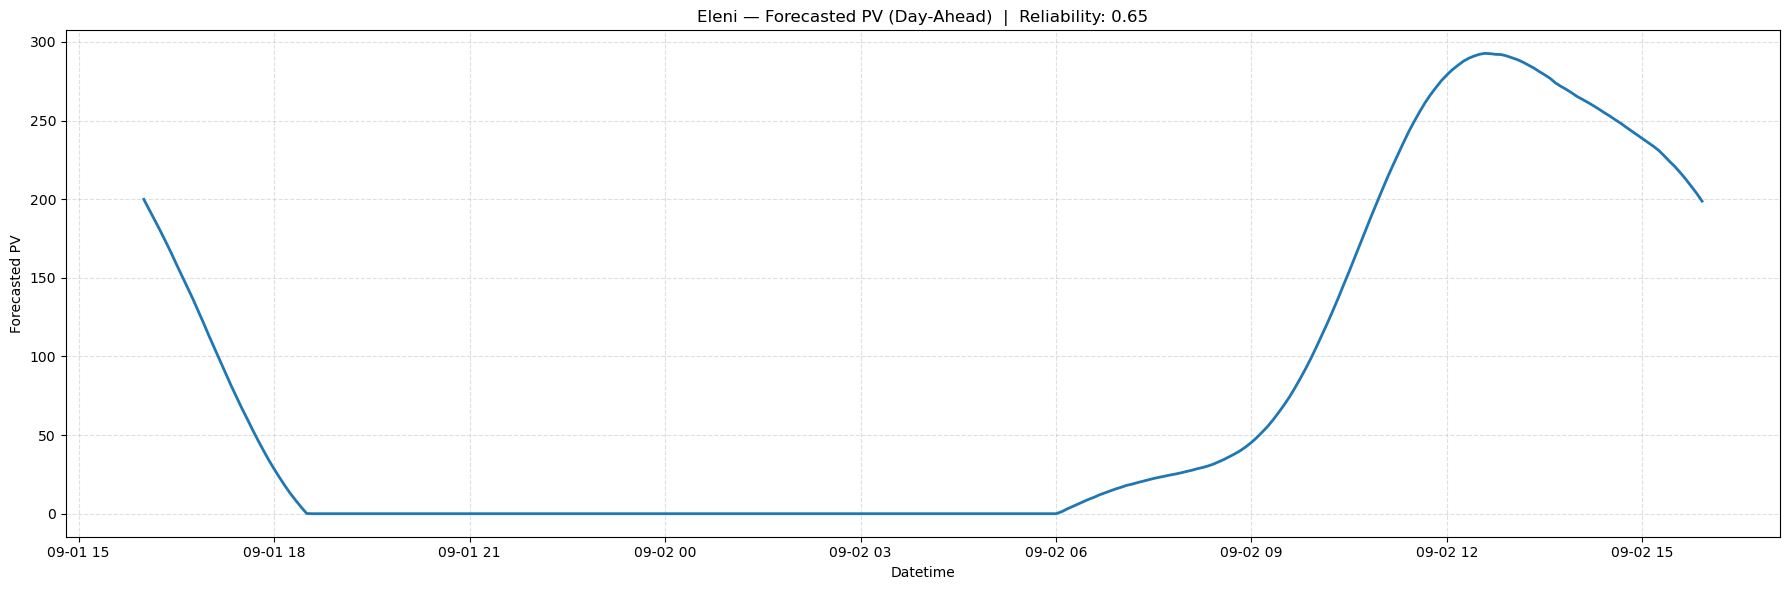

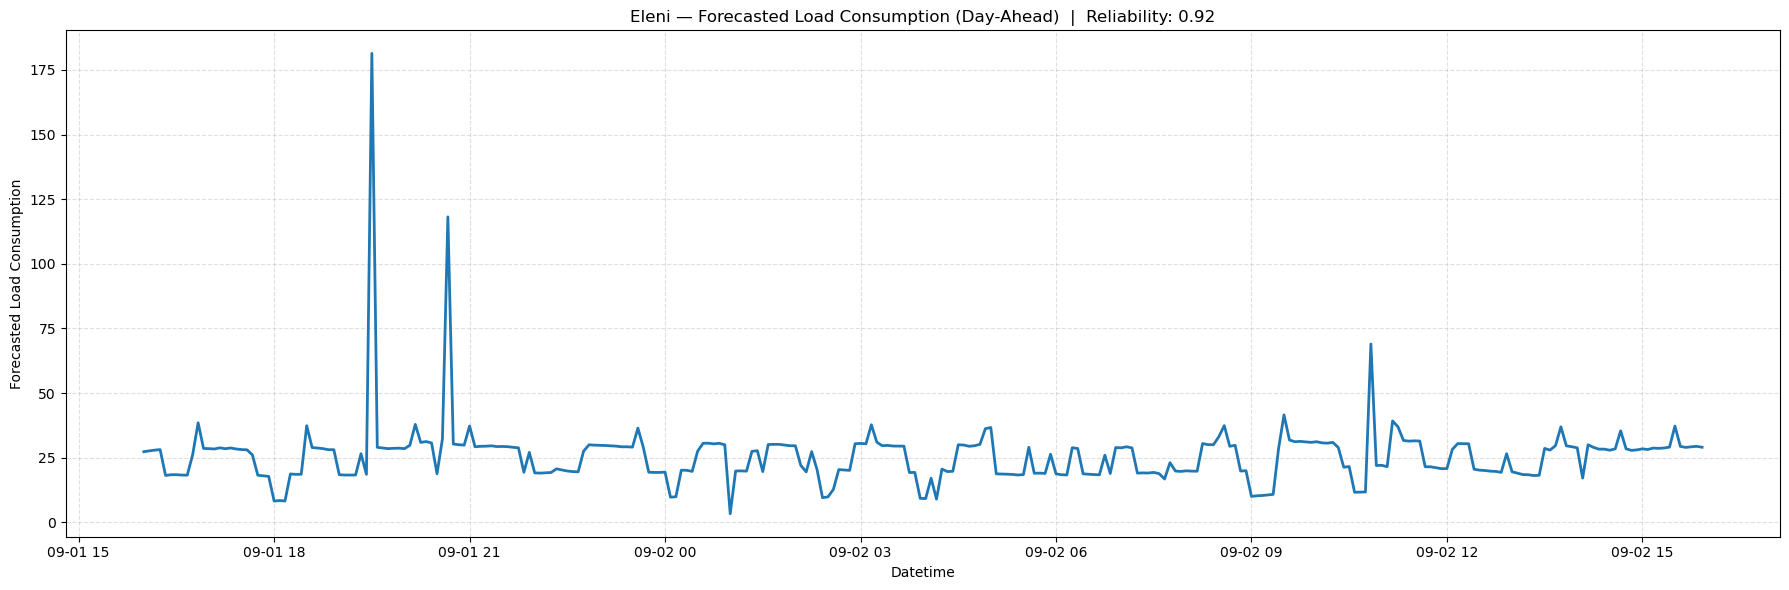

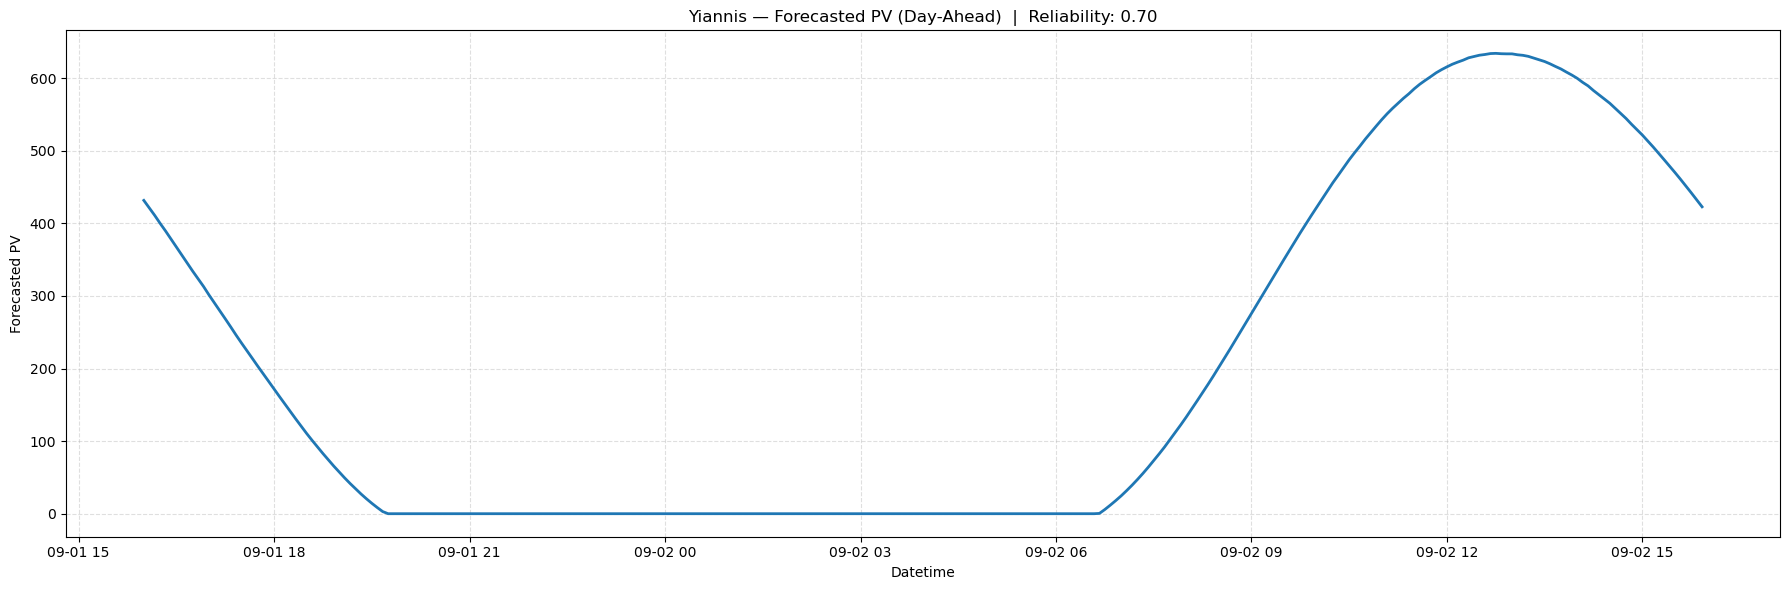

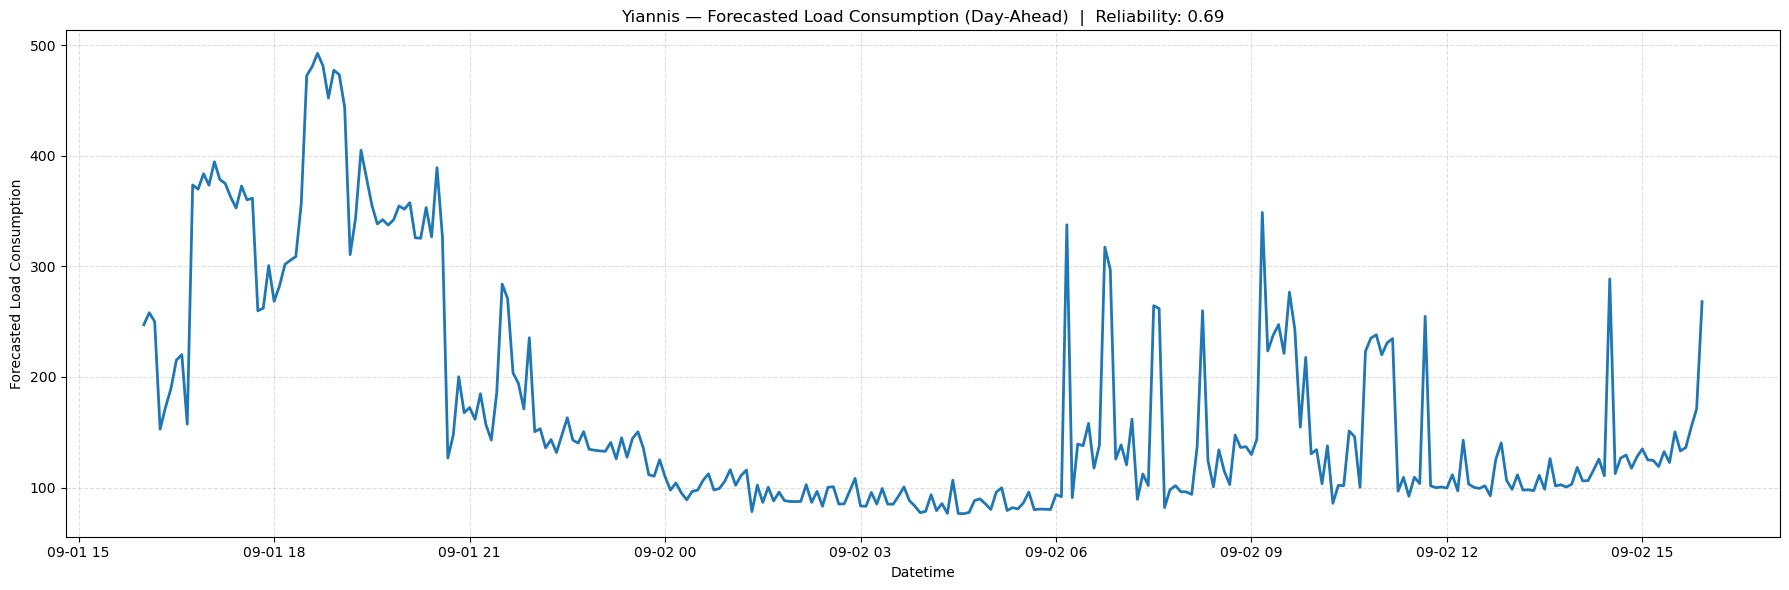

In [6]:
# === CELL 2: Plotting from the combined CSV ===================================
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = r"C:\Users\emine\source\repos\Dynamo\Dynamo"
FORECAST_PATH = str(Path(BASE_DIR, "Forecast_day_ahead_ALL_HOUSES.csv"))

# Load and prepare data
df = pd.read_csv(FORECAST_PATH)
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")
df = df.dropna(subset=["Datetime"]).sort_values(["House_ID", "Datetime"]).reset_index(drop=True)

# Plot per house (separate plots for PV and Load), show single reliability scalars in titles
for house in df["House_ID"].dropna().unique():
    sub = df[df["House_ID"] == house].copy().sort_values("Datetime")

    r_pv = sub["Reliability_PV_24h"].iloc[0] if "Reliability_PV_24h" in sub and sub["Reliability_PV_24h"].notna().any() else None
    r_ld = sub["Reliability_Load_24h"].iloc[0] if "Reliability_Load_24h" in sub and sub["Reliability_Load_24h"].notna().any() else None

    # Forecasted PV
    if "Forecasted_PV" in sub and sub["Forecasted_PV"].notna().any():
        plt.figure(figsize=(18, 6))
        plt.plot(sub["Datetime"], sub["Forecasted_PV"], linewidth=2)
        title = f"{house} — Forecasted PV (Day-Ahead)"
        if r_pv is not None:
            title += f"  |  Reliability: {r_pv:.2f}"
        plt.title(title)
        plt.xlabel("Datetime")
        plt.ylabel("Forecasted PV")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

    # Forecasted Load Consumption
    if "Forecasted_Load_Consumption" in sub and sub["Forecasted_Load_Consumption"].notna().any():
        plt.figure(figsize=(18, 6))
        plt.plot(sub["Datetime"], sub["Forecasted_Load_Consumption"], linewidth=2)
        title = f"{house} — Forecasted Load Consumption (Day-Ahead)"
        if r_ld is not None:
            title += f"  |  Reliability: {r_ld:.2f}"
        plt.title(title)
        plt.xlabel("Datetime")
        plt.ylabel("Forecasted Load Consumption")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()
